Statistical errors of CNN models

#read current
#load model and calculate out put od model
#plot 3d error of Bfield

In [9]:
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')
    
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset

Good to go


In [10]:
#load saved  model
num_input = 12
output_shape = (3,20,20,20)
SB_args = (64,64,4) # (Cin, Cout, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
Generative_network = torch.load('EMS_CNN.pt', map_location="cuda:0")
Generative_network.eval()
Generative_network.to(device)

Generative_net(
  (proj): Linear(in_features=12, out_features=8000, bias=True)
  (conv3d): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (total_net): Sequential(
    (0): Linear(in_features=12, out_features=8000, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 5, 5, 5))
    (2): BigBlock(
      (block): Sequential(
        (0): ResidualEMNSBlock_3d(
          (block): Sequential(
            (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): LeakyReLU(negative_slope=0.01)
          )
          (shortcut): Identity()
        )
        (1): ResidualEMNSBlock_3d(
          (block): Sequential(
            (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): LeakyReLU(ne

In [11]:
#load current and real magnetic field data
from ReadData import ReadCurrentAndField_CNN
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
current,data = ReadCurrentAndField_CNN (foldername,filepattern)
position = data[:,0:3,0:20,0:20,0:20]
Bfield = data[:,3:,0:20,0:20,0:20]

In [22]:
print("current shape:",current.shape,"current device:",current.device)
print("Bfied;:",Bfield.shape,"current device:",Bfield.device)

current shape: torch.Size([1000, 12]) current device: cpu
Bfied;: torch.Size([1000, 3, 20, 20, 20]) current device: cpu


In [12]:
#calculate estimated Bfield value of CNN 
B_est=torch.zeros(current.shape[0],3,20,20,20).cuda(0)

for i in range (0,current.shape[0]):
    input=current[i,:].cuda(0).reshape(1,12)
    b = input.float()
    B_est[i]=Generative_network(b)

B_est=B_est.cpu().detach().numpy()
Bfield=Bfield.detach().numpy()
current=current.detach().numpy()

In [17]:
Bdiff=np.absolute(B_est-Bfield*1000)
print(Bdiff.shape)
Error_CNN = Bdiff/Bfield*100


(1000, 3, 20, 20, 20)


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
loss = F.l1_loss(torch.tensor(B_est),torch.tensor(Bfield*1000))

print(loss)



current_index=0
print(current.shape)

z_plane_index= 10
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
vmin=[-50,-50,-50]
vmax=[50 , 50, 50]

# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est[current_index,i-1,:,:,z_plane_index])    
    plt.colorbar()
  

    plt.subplot(3,2,2*i)
    plt.imshow(Bfield[current_index,i-1,:,:,z_plane_index]*1000)
    plt.colorbar()

plt.show()

from pylab import *
subplots_adjust(left=0.0,bottom=0.0,top=1,right=1)
fig, ax = plt.subplots(1, 3)
fig.tight_layout()

for i in range(1,4):
    plt.subplot(1,3,i)
    plt.imshow(Error_CNN[current_index,i-1,:,:,z_plane_index])    
    plt.colorbar(fraction=0.04)    

plt.show()

TypeError: 'int' object is not callable

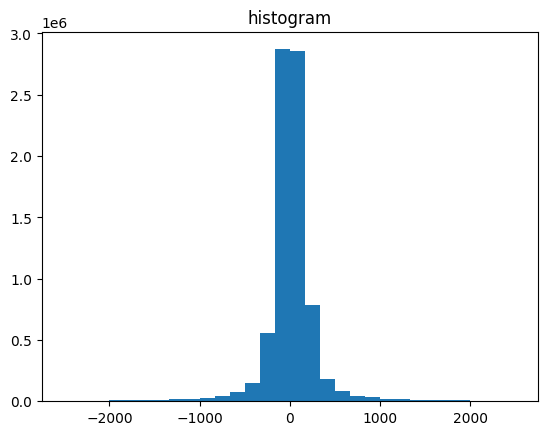

In [105]:
plt.hist(Error_CNN[:,0,:,:,:].reshape(-1),bins=30,range=[-2.5e3,2.5e3])
plt.title("histogram") 
plt.show()